In [3]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib as mpl
from artifactremoval.imgproc import npy_to_sitk
from scipy.ndimage import zoom
import shutil

# -- CONFIGURE YOUR BASE DIRECTORY HERE --
base_dir = r"E:\ArtifactRemovalProject\data\modelinference"

# ── 5. Utility: plot up to 15 spectra from a coord list ──────────────────────
def plot_spectra(coords, title, n_max=15):
    if len(coords) == 0:
        print(f"No voxels satisfy mask for «{title}»")
        return

    coords = coords[np.random.permutation(len(coords))]     # shuffle
    coords_raw = np.floor(coords).astype(int)               # int indices
    N        = min(n_max, len(coords_raw))
    n_cols   = 5
    n_rows   = int(np.ceil(N / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols*3, n_rows*2.5),
                             sharey=True)
    axes = axes.flatten()

    for i, (z, y, x) in enumerate(coords_raw[:N]):
        spectrum = np.real(spectral_arr[z, y, x, :])
        ax = axes[i]
        ax.plot(spectra_xaxis, spectrum, linewidth=2.0, color="black")
        ax.set_xlim(spectra_xaxis.max(), spectra_xaxis.min())   # invert ppm
        ax.set_ylim(-2000, 5000)
        ax.set_xlabel("ppm")
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_title(f"({z},{y},{x})", fontsize=8)

    # hide any unused sub-axes
    for j in range(N, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


In [9]:
# Prepare a mutable “turbo” colormap
cmap = mpl.cm.get_cmap("turbo").copy()
cmap.set_under('black')

# Iterate through subject/date subfolders
for subj_dir in glob.glob(os.path.join(base_dir, "*")) :
    if not os.path.isdir(subj_dir):
        continue
    for date_dir in glob.glob(os.path.join(subj_dir, "*")):
        if not os.path.isdir(date_dir):
            continue

        # File paths
        chonaa_path = os.path.join(date_dir, "chonaa.nii.gz")
        t1_path     = os.path.join(date_dir, "t1.nii.gz")
        s_pred_path = os.path.join(date_dir, "ypred_saumya.npy")
        m_prob_path = os.path.join(date_dir, "probs_vol_all_four.npy")
        qmap_path   = os.path.join(date_dir, "qmap.npy")
        cereb_path  = os.path.join(date_dir, "cerebellum_mask.nii.gz")        

        # Load images & arrays
        moving_img     = sitk.ReadImage(chonaa_path)
        fixed_img      = sitk.ReadImage(t1_path)

        # Read and resample cerebellum array to size of cho/naa and predictions array
        cereb       = sitk.ReadImage(cereb_path)
        cereb_r = sitk.Resample(cereb, moving_img, sitk.Transform(), sitk.sitkNearestNeighbor)

        # Load numpy arrays
        raw_chonaa_arr = sitk.GetArrayFromImage(moving_img)
        t1_arr         = sitk.GetArrayFromImage(fixed_img)
        cereb_arr      = sitk.GetArrayFromImage(cereb_r)

        # threshold Saumya's as normal
        s_pred_arr     = np.load(s_pred_path)[..., 1]
        s_pred_arr     = (s_pred_arr > 0.5).astype(np.uint8)

        # Load map and make masks 
        qmap_arr       = np.load(qmap_path)
        qmap_1         = (qmap_arr >= 1).astype(np.uint8)   # Brain Masks                     
        qmap_2         = (qmap_arr >= 2).astype(np.uint8)   # Water Linewidth test
        qmap_4         = (qmap_arr == 4).astype(np.uint8)   # All tests passed

        cerebellar_in_brain = (cereb_arr == 0) & (qmap_1 == 1)
        # Count of cerebellar voxels within brain, per slice
        num_cereb_voxels = np.sum(cerebellar_in_brain, axis=(1, 2))

        # Total brain voxels per slice
        num_brain_voxels = np.sum(qmap_1 == 1, axis=(1, 2))

        # Avoid divide-by-zero
        slice_fraction = np.divide(num_cereb_voxels, num_brain_voxels, out=np.zeros_like(num_cereb_voxels, dtype=np.float32), where=num_brain_voxels != 0)
        z_slices_strict = slice_fraction > 0.35  # tune this

        # Load new CNN probabilites
        m_prob_arr     = np.load(m_prob_path)
        # Create threshold map
        
        threshold_map = np.full(cereb_arr.shape,  0.8425752520561218, dtype=np.float32)  # default threshold from config
        threshold_map[z_slices_strict] = 0.80  # high threshold for z-slices that have cerebellar voxels
        threshold_map[cereb_arr == 0] = 0.70 # extremely high threshold for specifically cerebellar voxels

        # Threshold based on cerebellum or not
        m_pred_arr = (m_prob_arr < threshold_map).astype(int)

        # Apply brain mask to predictions
        m_pred_arr     = m_pred_arr * qmap_1
        s_pred_arr     = s_pred_arr * qmap_1
        print("loaded")

        # Count Acceptable Voxels in each Mask
        raw_count          = np.count_nonzero(qmap_1 == 1, axis=(1, 2)).reshape(-1, 1)
        s_pred_arr_count   = np.count_nonzero(s_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        m_pred_arr_count   = np.count_nonzero(m_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_2_count       = np.count_nonzero(qmap_2 == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_4_count       = np.count_nonzero(qmap_4 == 1, axis=(1, 2)).reshape(-1, 1)

        # 1) Create centered transform from moving→fixed
        transform = sitk.CenteredTransformInitializer(
            fixed_img,
            moving_img,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        transform = sitk.Transform(transform)

        # 2) Convert raw & predictions back to SITK
        y0 = moving_img
        y1 = npy_to_sitk(raw_chonaa_arr * s_pred_arr, y0)
        y2 = npy_to_sitk(raw_chonaa_arr * m_pred_arr, y0)
        y3 = npy_to_sitk(raw_chonaa_arr * qmap_2, y0)
        y4 = npy_to_sitk(raw_chonaa_arr * qmap_4, y0)

        # 3) Resample each into T1 space
        y0_r = sitk.Resample(y0, fixed_img, transform, sitk.sitkLinear, 0.0, y0.GetPixelID())
        y1_r = sitk.Resample(y1, fixed_img, transform, sitk.sitkLinear, 0.0, y1.GetPixelID())
        y2_r = sitk.Resample(y2, fixed_img, transform, sitk.sitkLinear, 0.0, y2.GetPixelID())
        y3_r = sitk.Resample(y3, fixed_img, transform, sitk.sitkLinear, 0.0, y3.GetPixelID())
        y4_r = sitk.Resample(y4, fixed_img, transform, sitk.sitkLinear, 0.0, y4.GetPixelID())
        print("resampled")

        # 4) Back to NumPy arrays
        base_arr   = sitk.GetArrayFromImage(y0_r)
        saumya_arr = sitk.GetArrayFromImage(y1_r)
        mine_arr   = sitk.GetArrayFromImage(y2_r)
        qmap2_arr  = sitk.GetArrayFromImage(y3_r)
        qmap4_arr  = sitk.GetArrayFromImage(y4_r)

        scale = raw_count.shape[0] / base_arr.shape[0]   
        lookup = np.rint(np.arange(base_arr.shape[0]) * scale).astype(int)

        # Precompute window/level for T1
        vmin_t1, vmax_t1 = np.percentile(t1_arr, [1, 99])
        vmin_o, vmax_o   = 0, 1.5

        output_dir = os.path.join(date_dir, r"images\regionthresholding_onlycereb")
        print(output_dir)

        # Delete folder if it exists
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)

        # Recreate the folder
        os.makedirs(output_dir)

        # Make sure output folder exists
        os.makedirs(output_dir, exist_ok=True)

        # 5) Loop a subset of slices and save PNGs
        for j in range(30, 140, 5):
            n_base = int(raw_count[lookup[j], 0])  
            n_s = int(s_pred_arr_count[lookup[j], 0])  
            n_m = int(m_pred_arr_count[lookup[j], 0])  
            n_q2 = int(qmap_2_count[lookup[j], 0])  
            n_q4 = int(qmap_4_count[lookup[j], 0])  

            anat   = t1_arr[j]
            base   = np.ma.masked_where(base_arr[j]   <= 0, base_arr[j])
            saumya = np.ma.masked_where(saumya_arr[j] <= 0, saumya_arr[j])
            mine   = np.ma.masked_where(mine_arr[j]   <= 0, mine_arr[j])
            q2     = np.ma.masked_where(qmap2_arr[j] <=0, qmap2_arr[j])
            q4     = np.ma.masked_where(qmap4_arr[j] <=0, qmap4_arr[j])

            fig, axes = plt.subplots(1, 5, figsize=(12, 4), facecolor='black')
            for ax in axes:
                ax.set_facecolor('black')
                ax.axis('off')

            titles = [
                f"Slice {j}\n{n_base} voxels total",
                f"QMAP >= 2 \n{n_q2} voxels",
                f"QMAP = 4 \n{n_q4} voxels",
                f"Saumya CNN \n{n_s} voxels",
                f"New CNN \n{n_m} voxels",
            ]

            print("making figures")
            for ax, overlay, title in zip(axes, (base, q2, q4, saumya, mine), titles):
                # Underlay T1
                ax.imshow(anat,
                          cmap='gray',
                          vmin=vmin_t1,
                          vmax=vmax_t1,
                          interpolation='nearest')
                # Overlay Cho/NAA
                ax.imshow(overlay,
                          cmap=cmap,
                          alpha=0.7,
                          vmin=vmin_o,
                          vmax=vmax_o,
                          interpolation='nearest')
                ax.set_title(title, color='white', fontsize=10)

            plt.tight_layout(pad=0.3)
            out_name = os.path.join(output_dir, f"slice_{j:03d}_comparison.png")
            fig.savefig(out_name,
                        dpi=300,
                        facecolor='black',
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close(fig)

print("All subjects processed and images saved.")

loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\images\regionthresholding_onlycereb
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\12.17.2018\images\regionthresholding_onlycereb
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_JH07\08.27.2018\images\

In [30]:
from scipy.ndimage import distance_transform_edt
# Prepare a mutable “turbo” colormap
cmap = mpl.cm.get_cmap("turbo").copy()
cmap.set_under('black')

# Iterate through subject/date subfolders
for subj_dir in glob.glob(os.path.join(base_dir, "*")) :
    if not os.path.isdir(subj_dir):
        continue
    for date_dir in glob.glob(os.path.join(subj_dir, "*")):
        if not os.path.isdir(date_dir):
            continue

        # File paths
        chonaa_path = os.path.join(date_dir, "chonaa.nii.gz")
        t1_path     = os.path.join(date_dir, "t1.nii.gz")
        s_pred_path = os.path.join(date_dir, "ypred_saumya.npy")
        m_prob_path = os.path.join(date_dir, "probs_vol_all_four.npy")
        qmap_path   = os.path.join(date_dir, "qmap.npy")
        cereb_path  = os.path.join(date_dir, "cerebellum_mask.nii.gz")        

        # Load images & arrays
        moving_img     = sitk.ReadImage(chonaa_path)
        fixed_img      = sitk.ReadImage(t1_path)

        # Read and resample cerebellum array to size of cho/naa and predictions array
        cereb       = sitk.ReadImage(cereb_path)
        cereb_r = sitk.Resample(cereb, moving_img, sitk.Transform(), sitk.sitkNearestNeighbor)

        # Load numpy arrays
        raw_chonaa_arr = sitk.GetArrayFromImage(moving_img)
        t1_arr         = sitk.GetArrayFromImage(fixed_img)
        cereb_arr      = sitk.GetArrayFromImage(cereb_r)

        # threshold Saumya's as normal
        s_pred_arr     = np.load(s_pred_path)[..., 1]
        s_pred_arr     = (s_pred_arr > 0.5).astype(np.uint8)

        # Load map and make masks 
        qmap_arr       = np.load(qmap_path)
        qmap_1         = (qmap_arr >= 1).astype(np.uint8)   # Brain Masks                     
        qmap_2         = (qmap_arr >= 2).astype(np.uint8)   # Water Linewidth test
        qmap_4         = (qmap_arr == 4).astype(np.uint8)   # All tests passed

        cerebellar_in_brain = (cereb_arr == 0) & (qmap_1 == 1)
        cereb_bin = cerebellar_in_brain.astype(np.bool_)
        # Count of cerebellar voxels within brain, per slice
        dist_from_cereb = distance_transform_edt(~(cereb_bin == 1)).astype(np.float32)

        # Parameters
        max_thresh = 0.8425752520561218
        min_thresh = 0.82
        decay_scale = 1  # controls how fast the threshold decays

        # Compute threshold map
        threshold_map = max_thresh - (max_thresh - min_thresh) * np.exp(-dist_from_cereb / decay_scale)
        # Load new CNN probabilites
        m_prob_arr     = np.load(m_prob_path)
        # Create threshold map
        
        #threshold_map = np.full(cereb_arr.shape,  0.8425752520561218, dtype=np.float32)  # default threshold from config
        #threshold_map[z_slices_strict] = 0.80  # high threshold for z-slices that have cerebellar voxels
        #threshold_map[cereb_arr == 0] = 0.70 # extremely high threshold for specifically cerebellar voxels

        # Threshold based on cerebellum or not
        m_pred_arr = (m_prob_arr < threshold_map).astype(int)

        # Apply brain mask to predictions
        m_pred_arr     = m_pred_arr * qmap_1
        s_pred_arr     = s_pred_arr * qmap_1
        print("loaded")

        # Count Acceptable Voxels in each Mask
        raw_count          = np.count_nonzero(qmap_1 == 1, axis=(1, 2)).reshape(-1, 1)
        s_pred_arr_count   = np.count_nonzero(s_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        m_pred_arr_count   = np.count_nonzero(m_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_2_count       = np.count_nonzero(qmap_2 == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_4_count       = np.count_nonzero(qmap_4 == 1, axis=(1, 2)).reshape(-1, 1)

        # 1) Create centered transform from moving→fixed
        transform = sitk.CenteredTransformInitializer(
            fixed_img,
            moving_img,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        transform = sitk.Transform(transform)

        # 2) Convert raw & predictions back to SITK
        y0 = moving_img
        y1 = npy_to_sitk(raw_chonaa_arr * s_pred_arr, y0)
        y2 = npy_to_sitk(raw_chonaa_arr * m_pred_arr, y0)
        y3 = npy_to_sitk(raw_chonaa_arr * qmap_2, y0)
        y4 = npy_to_sitk(raw_chonaa_arr * qmap_4, y0)
        y5 = npy_to_sitk(threshold_map, y0)

        # 3) Resample each into T1 space
        y0_r = sitk.Resample(y0, fixed_img, transform, sitk.sitkLinear, 0.0, y0.GetPixelID())
        y1_r = sitk.Resample(y1, fixed_img, transform, sitk.sitkLinear, 0.0, y1.GetPixelID())
        y2_r = sitk.Resample(y2, fixed_img, transform, sitk.sitkLinear, 0.0, y2.GetPixelID())
        y3_r = sitk.Resample(y3, fixed_img, transform, sitk.sitkLinear, 0.0, y3.GetPixelID())
        y4_r = sitk.Resample(y4, fixed_img, transform, sitk.sitkLinear, 0.0, y4.GetPixelID())
        y5_r = sitk.Resample(y5, fixed_img, transform, sitk.sitkLinear, 0.0, y5.GetPixelID())
        print("resampled")

        # 4) Back to NumPy arrays
        base_arr   = sitk.GetArrayFromImage(y0_r)
        saumya_arr = sitk.GetArrayFromImage(y1_r)
        mine_arr   = sitk.GetArrayFromImage(y2_r)
        qmap2_arr  = sitk.GetArrayFromImage(y3_r)
        qmap4_arr  = sitk.GetArrayFromImage(y4_r)
        threshold  = sitk.GetArrayFromImage(y5_r)

        scale = raw_count.shape[0] / base_arr.shape[0]   
        lookup = np.rint(np.arange(base_arr.shape[0]) * scale).astype(int)

        # Precompute window/level for T1
        vmin_t1, vmax_t1 = np.percentile(t1_arr, [1, 99])
        vmin_o, vmax_o   = 0, 1.5

        output_dir = os.path.join(date_dir, r"images\distancebased_threshold")
        print(output_dir)

        # Delete folder if it exists
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)

        # Recreate the folder
        os.makedirs(output_dir)

        # Make sure output folder exists
        os.makedirs(output_dir, exist_ok=True)

        # 5) Loop a subset of slices and save PNGs
        for j in range(30, 140, 5):
            n_base = int(raw_count[lookup[j], 0])  
            n_s = int(s_pred_arr_count[lookup[j], 0])  
            n_m = int(m_pred_arr_count[lookup[j], 0])  
            n_q2 = int(qmap_2_count[lookup[j], 0])  
            n_q4 = int(qmap_4_count[lookup[j], 0])  

            anat   = t1_arr[j]
            base   = np.ma.masked_where(base_arr[j]   <= 0, base_arr[j])
            saumya = np.ma.masked_where(saumya_arr[j] <= 0, saumya_arr[j])
            mine   = np.ma.masked_where(mine_arr[j]   <= 0, mine_arr[j])
            q2     = np.ma.masked_where(qmap2_arr[j] <=0, qmap2_arr[j])
            q4     = np.ma.masked_where(qmap4_arr[j] <=0, qmap4_arr[j])
            thresh = threshold[j]  # new threshold map slice

            fig, axes = plt.subplots(1, 6, figsize=(12, 4), facecolor='black')
            for ax in axes:
                ax.set_facecolor('black')
                ax.axis('off')

            titles = [
                f"Slice {j}\n{n_base} voxels total",
                f"QMAP >= 2 \n{n_q2} voxels",
                f"QMAP = 4 \n{n_q4} voxels",
                f"Saumya CNN \n{n_s} voxels",
                f"New CNN \n{n_m} voxels",
                "Threshold Map"
            ]

            print("making figures")
            for ax, overlay, title in zip(axes, (base, q2, q4, saumya, mine, thresh), titles):
                # Underlay T1
                ax.imshow(anat,
                          cmap='gray',
                          vmin=vmin_t1,
                          vmax=vmax_t1,
                          interpolation='nearest')
                # Use different colormap for threshold map
                if title == "Threshold Map":
                    ax.imshow(overlay,
                            cmap='hot',
                            alpha=0.8,
                            vmin=0.7,
                            vmax=0.85,
                            interpolation='nearest')
                else:
                    ax.imshow(overlay,
                            cmap=cmap,
                            alpha=0.7,
                            vmin=vmin_o,
                            vmax=vmax_o,
                            interpolation='nearest')
                ax.set_title(title, color='white', fontsize=9)

            plt.tight_layout(pad=0.3)
            out_name = os.path.join(output_dir, f"slice_{j:03d}_comparison.png")
            fig.savefig(out_name,
                        dpi=300,
                        facecolor='black',
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close(fig)

print("All subjects processed and images saved.")

loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\images\distancebased_threshold
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\12.17.2018\images\distancebased_threshold
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_JH07\08.27.2018\images\distanceba

In [4]:
from scipy.ndimage import distance_transform_edt
# Prepare a mutable “turbo” colormap
cmap = mpl.cm.get_cmap("turbo").copy()
cmap.set_under('black')

# Iterate through subject/date subfolders
for subj_dir in glob.glob(os.path.join(base_dir, "*")) :
    if not os.path.isdir(subj_dir):
        continue
    for date_dir in glob.glob(os.path.join(subj_dir, "*")):
        if not os.path.isdir(date_dir):
            continue

        # File paths
        chonaa_path = os.path.join(date_dir, "chonaa.nii.gz")
        t1_path     = os.path.join(date_dir, "t1.nii.gz")
        s_pred_path = os.path.join(date_dir, "ypred_saumya.npy")
        m_prob_path = os.path.join(date_dir, "probs_vol_all_four.npy")
        qmap_path   = os.path.join(date_dir, "qmap.npy")
        cereb_path  = os.path.join(date_dir, "cerebellum_mask.nii.gz")        

        # Load images & arrays
        moving_img     = sitk.ReadImage(chonaa_path)
        fixed_img      = sitk.ReadImage(t1_path)

        # Read and resample cerebellum array to size of cho/naa and predictions array
        cereb       = sitk.ReadImage(cereb_path)
        cereb_r = sitk.Resample(cereb, moving_img, sitk.Transform(), sitk.sitkNearestNeighbor)

        # Load numpy arrays
        raw_chonaa_arr = sitk.GetArrayFromImage(moving_img)
        t1_arr         = sitk.GetArrayFromImage(fixed_img)
        cereb_arr      = sitk.GetArrayFromImage(cereb_r)

        # threshold Saumya's as normal
        s_pred_arr     = np.load(s_pred_path)[..., 1]
        s_pred_arr     = (s_pred_arr > 0.5).astype(np.uint8)

        # Load map and make masks 
        qmap_arr       = np.load(qmap_path)
        qmap_1         = (qmap_arr >= 1).astype(np.uint8)   # Brain Masks                     
        qmap_2         = (qmap_arr >= 2).astype(np.uint8)   # Water Linewidth test
        qmap_4         = (qmap_arr == 4).astype(np.uint8)   # All tests passed

        cerebellar_in_brain = (cereb_arr == 0) & (qmap_1 == 1)
        cereb_bin = cerebellar_in_brain.astype(np.bool_)
        # Count of cerebellar voxels within brain, per slice
        dist_from_cereb = distance_transform_edt(~(cereb_bin == 1)).astype(np.float32)

        # Parameters
        max_thresh = 0.8425752520561218
        min_thresh = 0.82
        decay_scale = 1  # controls how fast the threshold decays

        # Compute threshold map
        threshold_map = max_thresh - (max_thresh - min_thresh) * np.exp(-dist_from_cereb / decay_scale)
        # Load new CNN probabilites
        m_prob_arr     = np.load(m_prob_path)

        # Threshold based on cerebellum or not
        m_pred_arr = (m_prob_arr < threshold_map).astype(int)

        # Apply brain mask to predictions
        m_pred_arr     = m_pred_arr * qmap_1
        s_pred_arr     = s_pred_arr * qmap_1
        print("loaded")

        # Count Acceptable Voxels in each Mask
        raw_count          = np.count_nonzero(qmap_1 == 1, axis=(1, 2)).reshape(-1, 1)
        s_pred_arr_count   = np.count_nonzero(s_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        m_pred_arr_count   = np.count_nonzero(m_pred_arr == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_2_count       = np.count_nonzero(qmap_2 == 1, axis=(1, 2)).reshape(-1, 1)
        qmap_4_count       = np.count_nonzero(qmap_4 == 1, axis=(1, 2)).reshape(-1, 1)

        # 1) Create centered transform from moving→fixed
        transform = sitk.CenteredTransformInitializer(
            fixed_img,
            moving_img,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        transform = sitk.Transform(transform)

        # 2) Convert raw & predictions back to SITK
        y0 = moving_img
        y1 = npy_to_sitk(raw_chonaa_arr * s_pred_arr, y0)
        y2 = npy_to_sitk(raw_chonaa_arr * m_pred_arr, y0)
        y3 = npy_to_sitk(raw_chonaa_arr * qmap_2, y0)
        y4 = npy_to_sitk(raw_chonaa_arr * qmap_4, y0)
        y5 = npy_to_sitk(threshold_map, y0)

        # 3) Resample each into T1 space
        y0_r = sitk.Resample(y0, fixed_img, transform, sitk.sitkLinear, 0.0, y0.GetPixelID())
        y1_r = sitk.Resample(y1, fixed_img, transform, sitk.sitkLinear, 0.0, y1.GetPixelID())
        y2_r = sitk.Resample(y2, fixed_img, transform, sitk.sitkLinear, 0.0, y2.GetPixelID())
        y3_r = sitk.Resample(y3, fixed_img, transform, sitk.sitkLinear, 0.0, y3.GetPixelID())
        y4_r = sitk.Resample(y4, fixed_img, transform, sitk.sitkLinear, 0.0, y4.GetPixelID())
        y5_r = sitk.Resample(y5, fixed_img, transform, sitk.sitkLinear, 0.0, y5.GetPixelID())
        print("resampled")

        # 4) Back to NumPy arrays
        base_arr   = sitk.GetArrayFromImage(y0_r)
        saumya_arr = sitk.GetArrayFromImage(y1_r)
        mine_arr   = sitk.GetArrayFromImage(y2_r)
        qmap2_arr  = sitk.GetArrayFromImage(y3_r)
        qmap4_arr  = sitk.GetArrayFromImage(y4_r)

        scale = raw_count.shape[0] / base_arr.shape[0]   
        lookup = np.rint(np.arange(base_arr.shape[0]) * scale).astype(int)

        # Precompute window/level for T1
        vmin_t1, vmax_t1 = np.percentile(t1_arr, [1, 99])
        vmin_o, vmax_o   = 0, 1.5

        output_dir = os.path.join(date_dir, r"images\distancebased_threshold_flair2")
        print(output_dir)

        # Delete folder if it exists
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)

        # Recreate the folder
        os.makedirs(output_dir)

        # Make sure output folder exists
        os.makedirs(output_dir, exist_ok=True)

        for j in range(30, 140, 5):
            n_base = int(raw_count[lookup[j], 0])  
            n_s = int(s_pred_arr_count[lookup[j], 0])  
            n_m = int(m_pred_arr_count[lookup[j], 0])  
            n_q2 = int(qmap_2_count[lookup[j], 0])  
            n_q4 = int(qmap_4_count[lookup[j], 0])  

            anat   = t1_arr[j]
            base   = np.ma.masked_where(base_arr[j]   <= 0, base_arr[j])
            saumya = np.ma.masked_where(saumya_arr[j] <= 0, saumya_arr[j])
            mine   = np.ma.masked_where(mine_arr[j]   <= 0, mine_arr[j])
            q2     = np.ma.masked_where(qmap2_arr[j] <= 0, qmap2_arr[j])
            q4     = np.ma.masked_where(qmap4_arr[j] <= 0, qmap4_arr[j])

            # === 🧠 Step 1: Find hot region in "mine" only ===
            #mine_mask = np.ma.getdata(mine) > np.percentile(np.ma.getdata(mine), 95)
            #if np.any(mine_mask):
            #    coords = np.argwhere(mine_mask)
            #    y_min, x_min = coords.min(axis=0)
            #    y_max, x_max = coords.max(axis=0)

            #    # Add padding
            #    pad = 3
            #    y_min = max(y_min - pad, 0)
            #    y_max = min(y_max + pad, anat.shape[0])
            #    x_min = max(x_min - pad, 0)
            #    x_max = min(x_max + pad, anat.shape[1])
            #else:
            #    y_min, y_max, x_min, x_max = 0, anat.shape[0], 0, anat.shape[1]

            # Extract unmasked data from mine overlay
            mine_data = np.ma.getdata(mine)

            # Define "hot" region as > 95th percentile
            hot_mask = mine_data > np.percentile(mine_data, 95)

            # Fallback: if no hot region, use full slice
            if not np.any(hot_mask):
                y_min, y_max = 0, anat.shape[0]
                x_min, x_max = 0, anat.shape[1]
            else:
                # --- Compute centroid of hot region ---
                coords = np.argwhere(hot_mask)
                centroid_y = int(np.round(coords[:, 0].mean()))
                centroid_x = int(np.round(coords[:, 1].mean()))

                # --- Define fixed crop size ---
                crop_h, crop_w = 100, 100
                half_h, half_w = crop_h // 2, crop_w // 2

                # --- Compute bounds centered on centroid ---
                y_min = max(centroid_y - half_h, 0)
                y_max = min(centroid_y + half_h, anat.shape[0])
                x_min = max(centroid_x - half_w, 0)
                x_max = min(centroid_x + half_w, anat.shape[1])

                # Adjust bounds if too tight at edges
                if y_max - y_min < crop_h:
                    if y_min == 0:
                        y_max = min(y_min + crop_h, anat.shape[0])
                    elif y_max == anat.shape[0]:
                        y_min = max(y_max - crop_h, 0)

                if x_max - x_min < crop_w:
                    if x_min == 0:
                        x_max = min(x_min + crop_w, anat.shape[1])
                    elif x_max == anat.shape[1]:
                        x_min = max(x_max - crop_w, 0)

            # === 🧠 Step 2: Apply same crop to all overlays ===
            fig, axes = plt.subplots(1, 5, figsize=(12, 4), facecolor='black')
            for ax in axes:
                ax.set_facecolor('black')
                ax.axis('off')

            titles = [
                f"Slice {j}\n{n_base} voxels total",
                f"QMAP >= 2 \n{n_q2} voxels",
                f"QMAP = 4 \n{n_q4} voxels",
                f"Saumya CNN \n{n_s} voxels",
                f"New CNN \n{n_m} voxels",
            ]
            overlays = [base, q2, q4, saumya, mine]

            print("making figures")

            for ax, overlay, title in zip(axes, overlays, titles):
                # Crop everything using same box
                anat_crop    = anat[y_min:y_max, x_min:x_max]
                overlay_crop = overlay[y_min:y_max, x_min:x_max]

                # Display cropped views
                ax.imshow(anat_crop,
                        cmap='gray',
                        vmin=vmin_t1,
                        vmax=vmax_t1,
                        interpolation='nearest')

                ax.imshow(overlay_crop,
                        cmap=cmap,
                        alpha=0.7,
                        vmin=vmin_o,
                        vmax=vmax_o,
                        interpolation='nearest')

                ax.set_title(title, color='white', fontsize=9)

            plt.tight_layout(pad=0.3)
            out_name = os.path.join(output_dir, f"slice_{j:03d}_comparison.png")
            fig.savefig(out_name,
                        dpi=300,
                        facecolor='black',
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close(fig)

        print("All subjects processed and images saved.")


loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\images\distancebased_threshold_flair2
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
All subjects processed and images saved.
loaded
resampled
E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\12.17.2018\images\distancebased_threshold_flair2
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
making figures
All subjects processed and images saved.
loaded
r

In [14]:
import os
import glob
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
from PIL import Image

# --- Config ---
FOLDER = "regionthresholding_onlycereb"
DPI = 400
SLIDE_WIDTH_IN = 13.33
SLIDE_HEIGHT_IN = 7.5
OUTPUT = "AllPatients_" + FOLDER + "_Combined.pptx"

# --- Base directory ---
base_dir = r"E:\ArtifactRemovalProject\data\modelinference"
output_pptx_path = os.path.join(base_dir, OUTPUT)

# --- Init presentation ---
prs = Presentation()
prs.slide_width = Inches(SLIDE_WIDTH_IN)
prs.slide_height = Inches(SLIDE_HEIGHT_IN)
blank_slide_layout = prs.slide_layouts[6]

# --- Collect images ---
image_paths = []
for subj_dir in glob.glob(os.path.join(base_dir, "*")):
    if not os.path.isdir(subj_dir):
        continue
    for date_dir in glob.glob(os.path.join(subj_dir, "*")):
        if not os.path.isdir(date_dir):
            continue

        image_dir = os.path.join(date_dir, "images", FOLDER)
        image_paths += glob.glob(os.path.join(image_dir, "*.png"))

# --- Sort for consistency ---
image_paths = sorted(image_paths)

# --- Insert each image and title ---
for image_path in image_paths:
    # Extract subject and date from path
    parts = image_path.split(os.sep)
    subject = parts[-5]
    date = parts[-4]
    title_text = f"Subject: {subject}    Date: {date}"

    # Load image size
    with Image.open(image_path) as img:
        width_px, height_px = img.size

    # Convert to inches
    width_in = width_px / DPI
    height_in = height_px / DPI

    # Scale up while preserving aspect ratio
    scale = 4  # ← increase as desired
    scaled_width = width_in * scale
    scaled_height = height_in * scale

    # Ensure it fits within the slide
    if scaled_width > SLIDE_WIDTH_IN:
        scale = SLIDE_WIDTH_IN / width_in
    if scaled_height > SLIDE_HEIGHT_IN:
        scale = min(scale, SLIDE_HEIGHT_IN / height_in)

    # Final scaled size
    final_width = width_in * scale
    final_height = height_in * scale

    # Center on slide
    left = Inches((SLIDE_WIDTH_IN - final_width) / 2)
    top = Inches((SLIDE_HEIGHT_IN - final_height) / 2)

    # Add slide
    slide = prs.slides.add_slide(blank_slide_layout)

    # Add image
    slide.shapes.add_picture(image_path, left, top,
                             width=Inches(final_width),
                             height=Inches(final_height))

    # Add title box
    title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.1), Inches(12.5), Inches(0.5))
    text_frame = title_box.text_frame
    p = text_frame.paragraphs[0]
    run = p.add_run()
    run.text = title_text
    run.font.size = Pt(18)
    run.font.bold = True
    run.font.color.rgb = RGBColor(255, 255, 255)  # white
    title_box.fill.solid()
    title_box.fill.fore_color.rgb = RGBColor(0, 0, 0)  # black background

print(f"Total slides created: {len(image_paths)}")
prs.save(output_pptx_path)
print(f"Saved combined PowerPoint to: {output_pptx_path}")


Total slides created: 154
Saved combined PowerPoint to: E:\ArtifactRemovalProject\data\modelinference\AllPatients_regionthresholding_onlycereb_Combined.pptx


In [ ]:
moving_img = sitk.ReadImage(r"E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\chonaa.nii.gz")
cereb = sitk.ReadImage(r"E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\cerebellum_mask.nii.gz")
cereb_r = sitk.Resample(cereb, moving_img, sitk.Transform(), sitk.sitkNearestNeighbor)
cereb_arr      = sitk.GetArrayFromImage(cereb_r)

cerebellar_in_brain = (cereb_arr == 0) & (qmap_1 == 1)
cereb_bin = cerebellar_in_brain.astype(np.bool_)
slice_fraction = np.mean(cereb_arr == 0, axis=(1, 2))  # fraction of voxels per slice that are cerebellar
z_slices_strict = slice_fraction > 0.30  # adjust threshold (e.g., 10%)
z_slices_with_cerebellum = np.any(cereb_arr == 0, axis=(1, 2))  # shape: [Z]


# Debug output
print("Total slices:", cereb_arr.shape[0])
print("Number of slices with cerebellum STRICT:", np.sum(z_slices_strict))
print("Number of slices with cerebellum:", np.sum(z_slices_with_cerebellum))

Total slices: 32
Number of slices with cerebellum STRICT: 4
Number of slices with cerebellum: 32


Total candidates found: 87 voxels


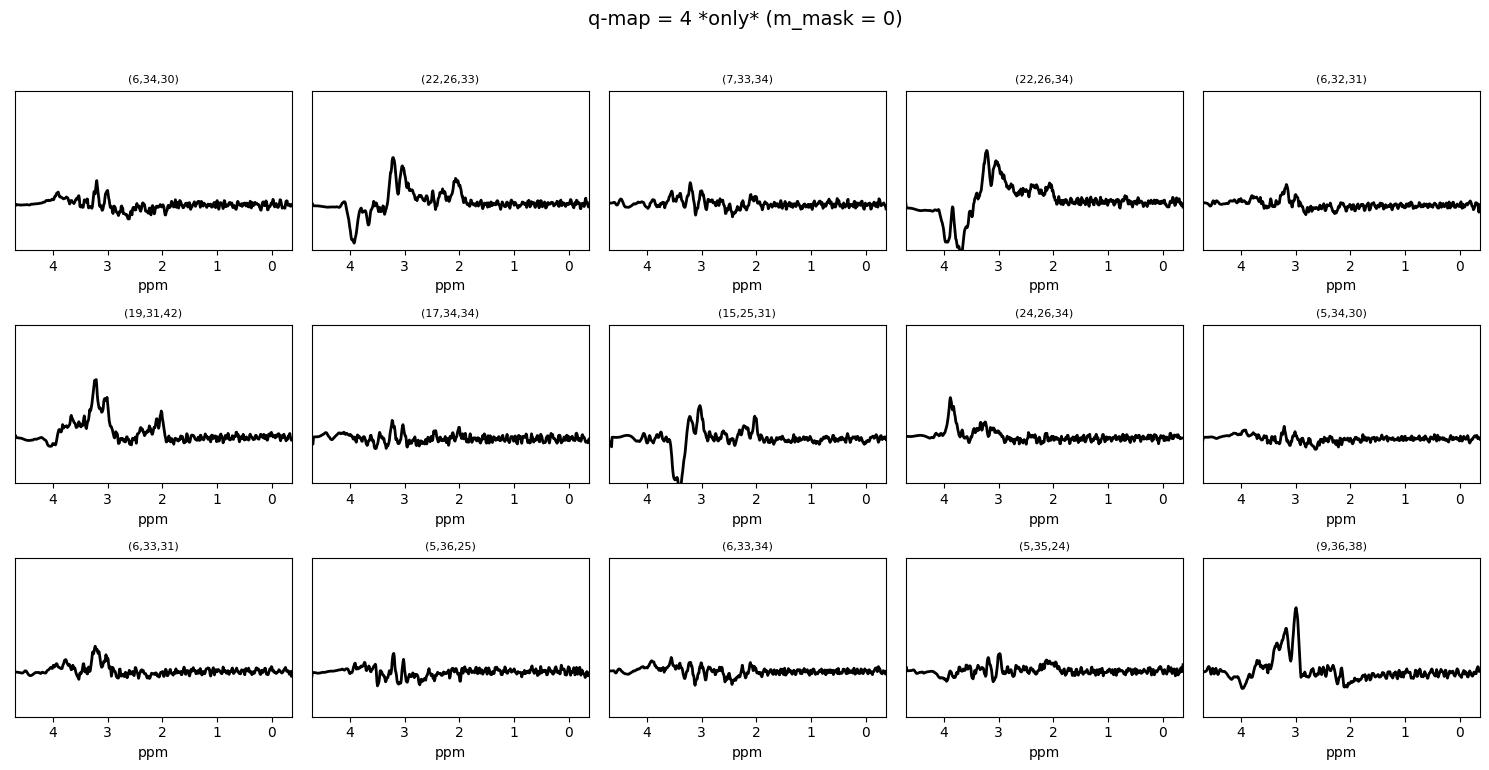

In [ ]:
# compare saumya's algorithm with my algorithm

import json
from pathlib import Path

basedir = Path("E:\ArtifactRemovalProject\data\modelinference")
input_dir = basedir / "rGBM_001_02_27_2023" / "02.27.2023"


chonaapath = input_dir / "chonaa.nii.gz"
mypredspath = input_dir / "preds_vol_all_four.npy"
spredspath = input_dir / "ypred_saumya.npy"
specarrpath = input_dir / "si.npy"

chonaa = sitk.ReadImage(chonaapath)
chonaa_arr = sitk.GetArrayFromImage(chonaa)
m_mask_arr = np.load(mypredspath)
s_mask_arr = np.load(spredspath)[:,:,:,1]
s_mask_bin = (s_mask_arr >= 0.5).astype(np.uint8)
spectral_arr = np.load(specarrpath)

# --- Load averaged sampling info from JSON ---
with open("avg_spectral_sampling.json", "r") as f:
    spec_sample = json.load(f)

# --- Build ppm x-axis (high to low) ---
spectra_xaxis = np.linspace(
    spec_sample['left_edge_ppm'],
    spec_sample['left_edge_ppm'] - spec_sample['ppm_range'],
    int(spec_sample['spec_pts'])
)

# 1) Compute chonaa threshold: mean + 2*std over non-zero
ch_vals = chonaa_arr[chonaa_arr > 0]
threshold = ch_vals.mean() + 2 * ch_vals.std()

# 2) Identify voxels: Saumya predicted 0, Mine predicted 1, and high chonaa
mask = (s_mask_bin == 0) & (m_mask_arr == 1) & (chonaa_arr > threshold)
coords = np.argwhere(mask)
print(f"Total candidates found: {len(coords)} voxels")

coords_raw = np.floor(coords).astype(int)  # shape (M,3)

plot_spectra(coords_raw, "q-map = 4 *only* (m_mask = 0)")


Casting complex values to real discards the imaginary part


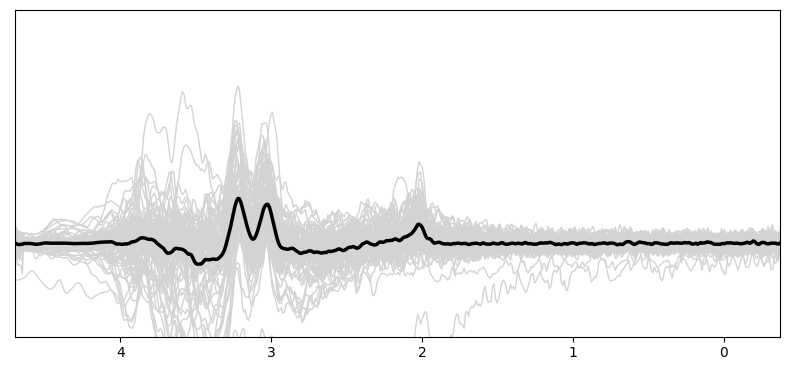

In [ ]:
# --- Set black background and white axis text ---
plt.style.use('default')

N = len(coords_raw)
spectra_stack = []

# Collect spectra
for z, y, x in coords_raw[:N]:
    spectra_stack.append(spectral_arr[z, y, x, :])

spectra_stack = np.stack(spectra_stack)  # shape (N, 512)
mean_spectrum = spectra_stack.mean(axis=0)

# Plot all spectra in light gray
plt.figure(figsize=(8, 4))
for spectrum in spectra_stack:
    plt.plot(spectra_xaxis, spectrum, color='lightgray', linewidth=1.0)

# Overlay average spectrum in bright white
plt.plot(spectra_xaxis, mean_spectrum, color='black', linewidth=2.5, label='Mean')

plt.xlabel("ppm", color='white')
plt.xlim(spectra_xaxis.max(), spectra_xaxis.min())  # invert ppm axis
plt.yticks([])  # remove y-axis ticks
plt.ylim(-2000, 5000)  # ← your y-axis range
plt.tight_layout()
plt.show()

210 voxels in q-map only
887 voxels in mask only


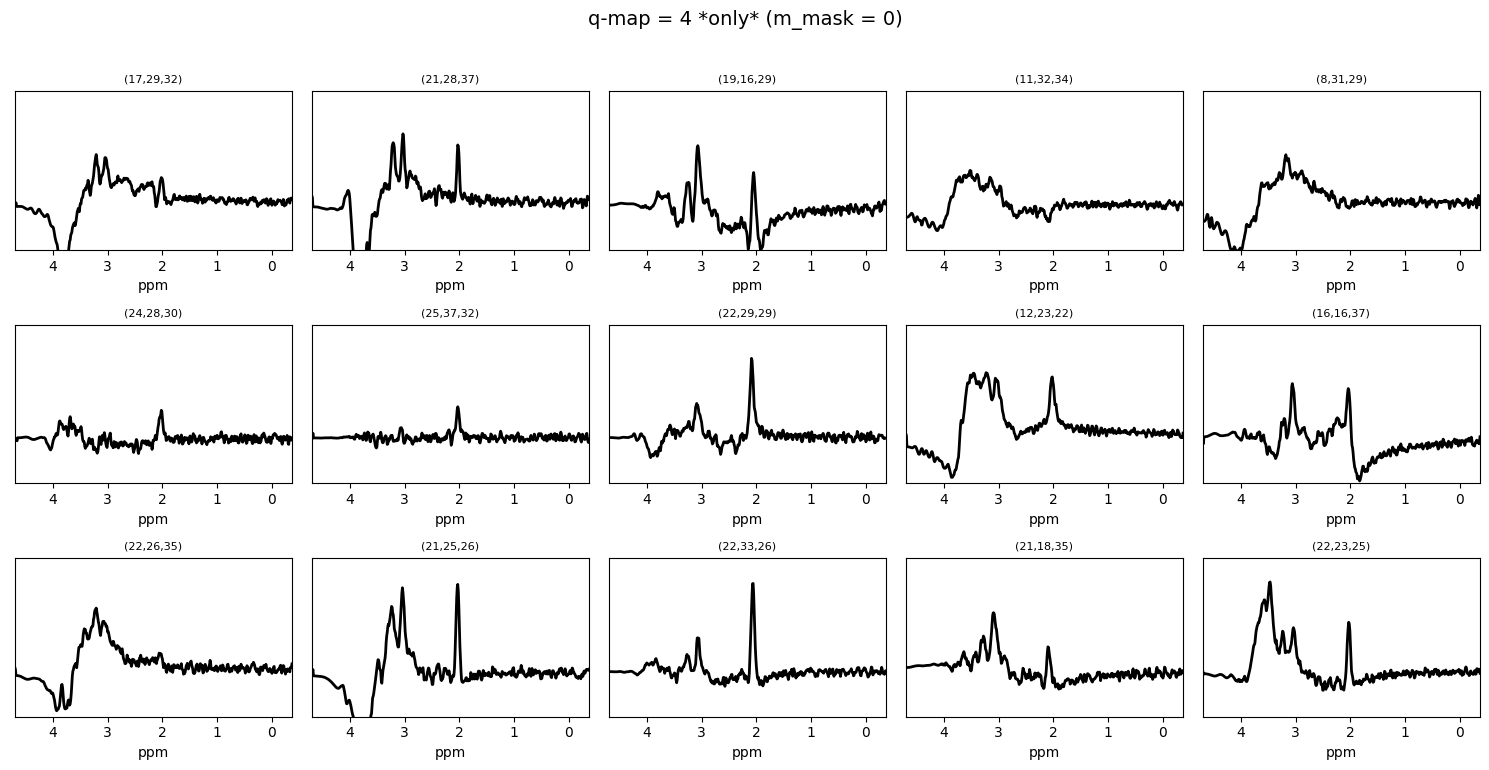

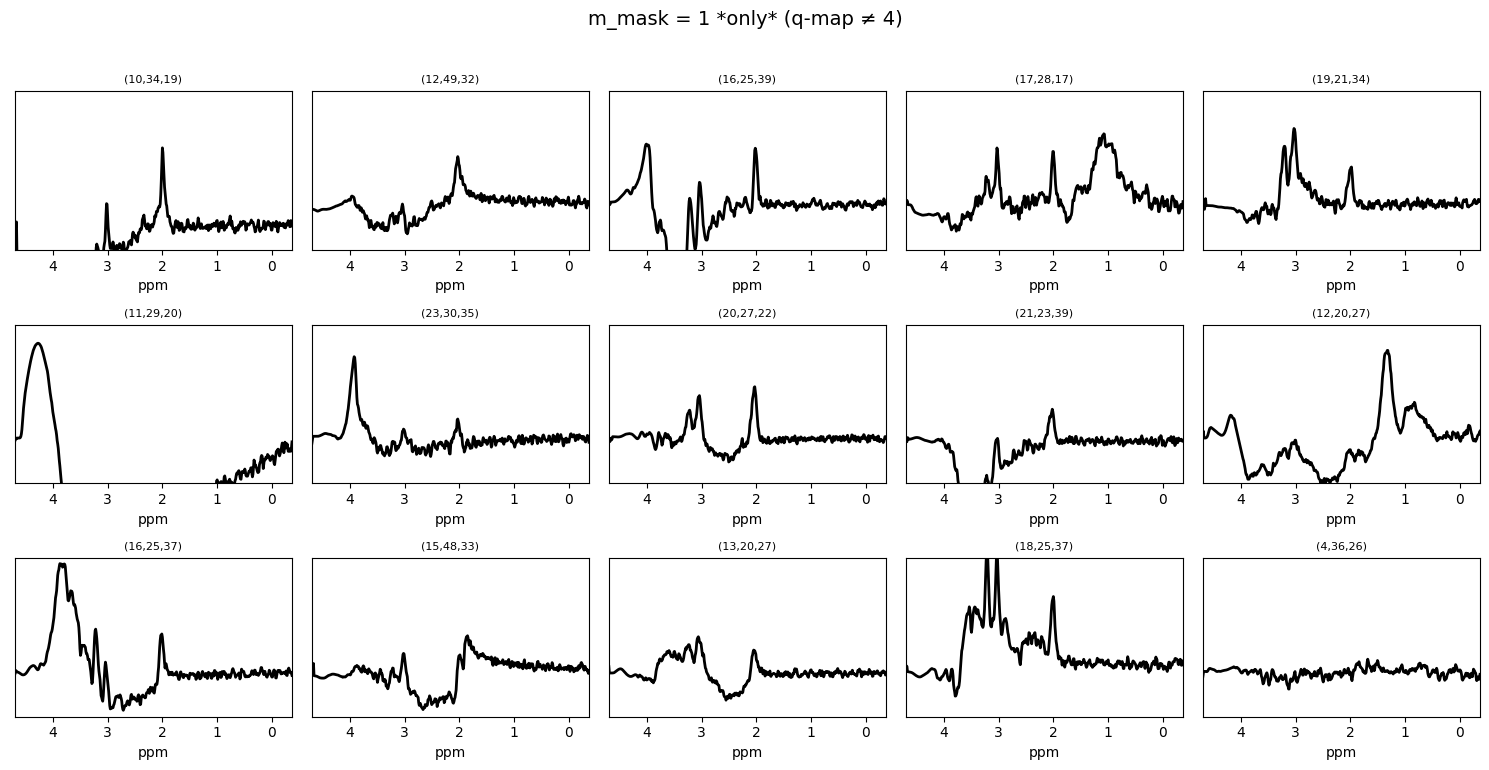

In [ ]:
# compare my algorithm with qmaps = 4
basedir = Path("E:\ArtifactRemovalProject\data\modelinference")
input_dir = basedir / "rGBM_001_02_27_2023" / "02.27.2023"

chonaapath = input_dir / "chonaa.nii.gz"
mypredspath = input_dir / "preds_vol_all_four.npy"
qmap = input_dir / "qmap.npy"
specarrpath = input_dir / "si.npy"

chonaa = sitk.ReadImage(chonaapath)
chonaa_arr = sitk.GetArrayFromImage(chonaa)
m_mask_arr = np.load(mypredspath) # 1 is acceptable # 0 is not
qmap_arr       = np.load(qmap_path)
qmap_1         = (qmap_arr >= 1).astype(np.uint8)                        
#qmap_2         = (qmap_arr >= 2).astype(np.uint8)
qmap_4         = (qmap_arr == 4).astype(np.uint8)
m_mask_arr = m_mask_arr * qmap_1
spectral_arr = np.load(specarrpath)

# ── 3. Logical masks & voxel indices ─────────────────────────────────────────
fn_mask = np.logical_and(qmap_4 == 1, m_mask_arr == 0)   # q-map only (false-neg)
fp_mask = np.logical_and(m_mask_arr == 1, qmap_4 == 0)   # mask only (false-pos)

fn_coords = np.argwhere(fn_mask)   # shape (N_fn, 3) – (z, y, x)
fp_coords = np.argwhere(fp_mask)   # shape (N_fp, 3)

print(f"{len(fn_coords):,} voxels in q-map only")  # optional sanity checks
print(f"{len(fp_coords):,} voxels in mask only")

# --- Load averaged sampling info from JSON ---
with open("avg_spectral_sampling.json", "r") as f:
    spec_sample = json.load(f)

# --- Build ppm x-axis (high to low) ---
spectra_xaxis = np.linspace(
    spec_sample['left_edge_ppm'],
    spec_sample['left_edge_ppm'] - spec_sample['ppm_range'],
    int(spec_sample['spec_pts'])
)
# ── 6. Draw spectra for each category ────────────────────────────────────────
plot_spectra(fn_coords, "q-map = 4 *only* (m_mask = 0)")
plot_spectra(fp_coords, "m_mask = 1 *only* (q-map ≠ 4)")

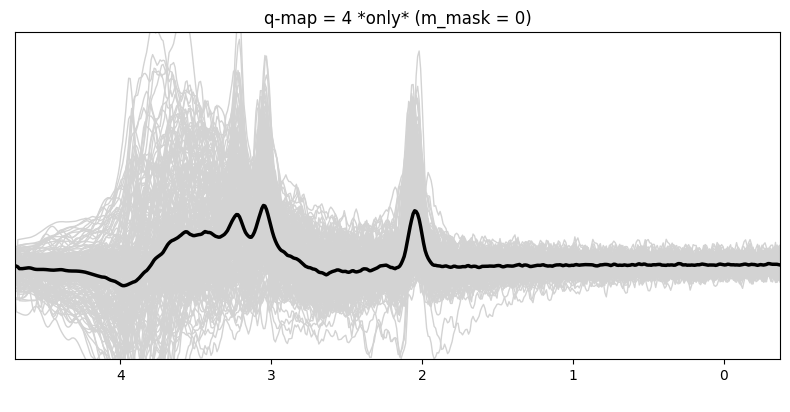

In [ ]:
# --- Set black background and white axis text ---
plt.style.use('default')

N = len(fn_coords)
spectra_stack = []

# Collect spectra
for z, y, x in fn_coords[:N]:
    spectra_stack.append(np.real(spectral_arr[z, y, x, :]))

spectra_stack = np.stack(spectra_stack)  # shape (N, 512)
mean_spectrum = spectra_stack.mean(axis=0)

# Plot all spectra in light gray
plt.figure(figsize=(8, 4))
for spectrum in spectra_stack:
    plt.plot(spectra_xaxis, spectrum, color='lightgray', linewidth=1.0)

# Overlay average spectrum in bright white
plt.plot(spectra_xaxis, mean_spectrum, color='black', linewidth=2.5, label='Mean')

plt.xlabel("ppm", color='white')
plt.xlim(spectra_xaxis.max(), spectra_xaxis.min())  # invert ppm axis
plt.yticks([])  # remove y-axis ticks
plt.ylim(-2000, 5000)  # ← your y-axis range
plt.tight_layout()
plt.title("q-map = 4 *only* (m_mask = 0)")
plt.show()

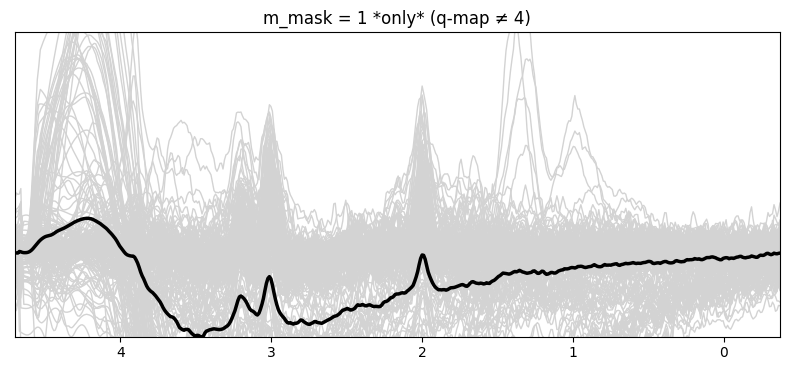

In [ ]:
# --- Set black background and white axis text ---
plt.style.use('default')

N = len(fn_coords)
spectra_stack = []

# Collect spectra
for z, y, x in fp_coords[:N]:
    spectra_stack.append(np.real(spectral_arr[z, y, x, :]))

spectra_stack = np.stack(spectra_stack)  # shape (N, 512)
mean_spectrum = spectra_stack.mean(axis=0)

# Plot all spectra in light gray
plt.figure(figsize=(8, 4))
for spectrum in spectra_stack:
    plt.plot(spectra_xaxis, spectrum, color='lightgray', linewidth=1.0)

# Overlay average spectrum in bright white
plt.plot(spectra_xaxis, mean_spectrum, color='black', linewidth=2.5, label='Mean')

plt.xlabel("ppm", color='white')
plt.xlim(spectra_xaxis.max(), spectra_xaxis.min())  # invert ppm axis
plt.yticks([])  # remove y-axis ticks
plt.ylim(-2000, 5000)  # ← your y-axis range
plt.title("m_mask = 1 *only* (q-map ≠ 4)")
plt.tight_layout()
plt.show()

In [ ]:
import pickle

# 1) Path to your pickle file
pickle_path = r"E:\ArtifactRemovalProject\data\ratings\aggregate_data\spectral_test_20250423_1640.pkl"

# 2) Load the pickle
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

# 3) Inspect what you’ve got
if isinstance(data, dict):
    print("Keys in pickle:", list(data.keys()))
else:
    print("Loaded object is a", type(data))

# 3) Inspect the first element
first = data[0]
print("Type of first element:", type(first))

# 4) If it’s a dict, show its keys
if isinstance(first, dict):
    print("Keys in element[0]:", list(first.keys()))
# If it’s a custom object, show its attributes
elif hasattr(first, "__dict__"):
    print("Attributes on element[0]:", list(vars(first).keys()))
else:
    # Fallback: pretty-print a small slice
    import pprint
    pprint.pprint(first, depth=2)


Loaded object is a <class 'list'>
Type of first element: <class 'dict'>
Keys in element[0]: ['unique_id', 'spectral_sampling', 'spectral_siref_sampling', 'raw_spectrum', 'water_siref', 'midas_fit', 'nnfit', 'subject_id', 'study_date', 'study_folder', 'slice_folder', 'assigned_raters', 'consensus_rating']


In [ ]:
spectral_sampling_list = [d["spectral_sampling"] for d in data]
spectral_sampling_list[2]

{'hz_per_ppm': 123.258107,
 'spec_pts': 512,
 'freq_offset': -2.53533,
 'chem_shift_ref': 4.7,
 'spec_width': 625.0,
 'hz_per_pt': 1.220703125,
 'ppm_range': 5.07066038260672,
 'ppm_per_pt': 0.00990363355977875,
 'center_ppm': 2.16467,
 'left_edge_ppm': 4.70000019130336}

In [ ]:
import json
# Step 1: Keys to average (float-valued fields only)
keys_to_average = [
    'hz_per_ppm', 'spec_pts', 'freq_offset', 'chem_shift_ref', 'spec_width',
    'hz_per_pt', 'ppm_range', 'ppm_per_pt', 'center_ppm', 'left_edge_ppm'
]

# Step 2: Stack values for each key
averaged_sampling = {}
for key in keys_to_average:
    values = [d[key] for d in spectral_sampling_list]
    averaged_sampling[key] = float(np.mean(values))

# Step 3: Save to a JSON file
output_path = "avg_spectral_sampling.json"
with open(output_path, "w") as f:
    json.dump(averaged_sampling, f, indent=4)

print(f"Averaged sampling info saved to {output_path}")

Averaged sampling info saved to avg_spectral_sampling.json


In [ ]:
qmap_path = r"E:\ArtifactRemovalProject\data\modelinference\DOSEESC_EM09\11.20.2018\qmap.npy"
qmap = np.load(qmap_path)

# mask 1: 1 where arr ≥ 2, else 0
mask_ge2 = (qmap >= 2).astype(np.uint8)   # or .astype(int)
# mask 2: 1 where arr == 4, else 0
mask_eq4 = (qmap == 4).astype(np.uint8)

[0 1 2 4]


(32, 64, 64)


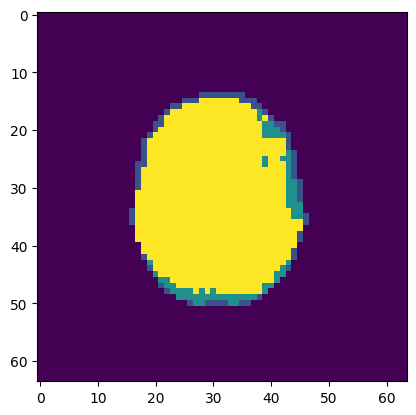

In [ ]:
print(qmap.shape)
plt.imshow(qmap[16,:,:])

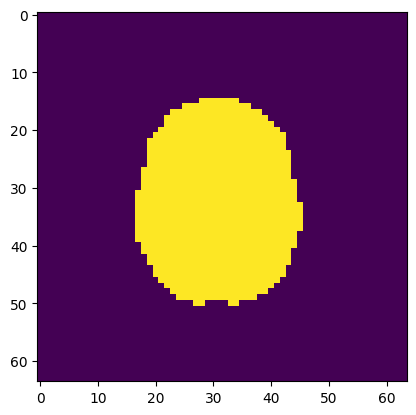

In [ ]:
plt.imshow(mask_ge2[16,:,:])

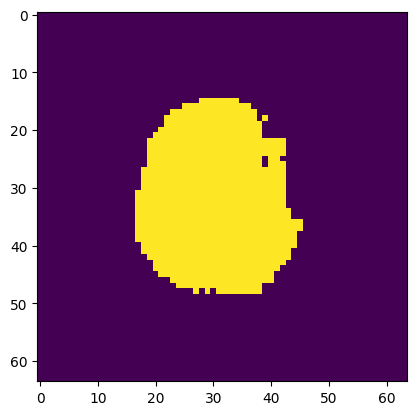

In [ ]:
plt.imshow(mask_eq4[16,:,:])